# XLNET TRANSFORMERS MODEL

In [ ]:
!pip install transformers
!pip install torch
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.1 MB/s 
     |████████████████████████████████| 163 kB 54.5 MB/s 
     |████████████████████████████████| 7.6 MB 53.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.0 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
!pip install -q -U watermark

     |████████████████████████████████| 1.6 MB 5.2 MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.14
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.23.1



In [ ]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/News_Dataset/Data/Sentiment Analysis/All_Label_Covid_Headlines.csv')
df.head()

,Month,Date,Headline_Original,Sentiment,Headline_Clean
0,April,"Updated: Apr 17, 2020 15:28 IST","Rs 500 notes lay on Delhi street, no one touch...",0,rs note lay delhi street no one touch due coro...
1,April,"Updated: Apr 17, 2020 14:19 IST",Charu Asopa on trolls attacking her over pics ...,0,charu asopa troll attack pics husband keep thi...
2,April,"Updated: Apr 17, 2020 13:54 IST",People abandoning their pets are cruel and ign...,0,people abandon pet cruel ignorant richa
3,April,"Updated: Apr 17, 2020 12:42 IST",Indian women's hockey team to raise funds for ...,0,indian women hockey team raise fund poor affec...
4,April,"Updated: Apr 17, 2020 12:42 IST",Real estate sector faces serious setback due t...,0,real estate sector face serious setback due re...


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,Month,Date,Headline_Original,Sentiment,Headline_Clean
5852,June,"Updated: Jun 11, 2020 16:15 IST",‘Safe zones' in Pune see rise in cases; PMC re...,1,safe zone pune see rise case pmc ready tackle ...
1520,May,"Updated: May 13, 2020 12:33 IST","Over 14,500 cases in Mumbai, nearly 5,000 in C...",0,case mumbai nearly chennai list top cities
5481,April,"Updated: Apr 06, 2020 23:22 IST","MPs, experts join forces to form Covid-19 acti...",1,mps experts join force form action group
1054,May,"Updated: May 08, 2020 23:05 IST",Jalandhar Rural police bust gang of drug smugg...,0,jalandhar rural police bust gang drug smuggler...
1318,August,"Updated: August 15, 2020 7:48:21 pm",Barcelona's worst defeat in almost 80 years ex...,0,barcelona worst defeat almost years expose pro...
6533,August,"Updated: August 26, 2020 7:56:22 am",James Anderson gets milestone 600th as England...,1,james anderson get milestone england win test ...
9373,November,"Published: 23:04 GMT, 3 November 2020",New England's two Republican governors break a...,1,new england two republican governors break awa...
1242,August,"Updated: August 2, 2020 3:47:48 pm",Bengal: Covid load gets heavier after a grim J...,0,bengal covid load get heavier grim july test t...
1430,October,"October 9, 2020 2:02:57 pm",Remote teaching professionals in demand as tra...,0,remote teach professionals demand traditional ...
10633,October,"October 7, 2020 11:22:05 pm",High patient dropout rate in AntiVEGF therapy ...,1,high patient dropout rate antivegf therapy due...


In [ ]:
import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

In [ ]:
df['Headline_Clean'] = df['Headline_Clean'].apply(clean_text)

In [ ]:
df

,Month,Date,Headline_Original,Sentiment,Headline_Clean
5852,June,"Updated: Jun 11, 2020 16:15 IST",‘Safe zones' in Pune see rise in cases; PMC re...,1,safe zone pune see rise case pmc ready tackle ...
1520,May,"Updated: May 13, 2020 12:33 IST","Over 14,500 cases in Mumbai, nearly 5,000 in C...",0,case mumbai nearly chennai list top cities
5481,April,"Updated: Apr 06, 2020 23:22 IST","MPs, experts join forces to form Covid-19 acti...",1,mps experts join force form action group
1054,May,"Updated: May 08, 2020 23:05 IST",Jalandhar Rural police bust gang of drug smugg...,0,jalandhar rural police bust gang drug smuggler...
1318,August,"Updated: August 15, 2020 7:48:21 pm",Barcelona's worst defeat in almost 80 years ex...,0,barcelona worst defeat almost years expose pro...
...,...,...,...,...,...
6606,September,"Updated: September 12, 2020 8:38:53 am","Told to increase ICU beds, some Delhi hospital...",1,told increase icu bed delhi hospitals say full...
1796,April,"Apr 9, 2020",Small cinemas in Kansai turn to T-shirts as th...,0,small cinemas kansai turn struggle pandemic
908,April,"Updated: Apr 26, 2020 14:40 IST",Google decodes why remote video calls do not e...,0,google decode remote video call not excite wor...
5383,April,"Updated: Apr 10, 2020 15:44 IST","Asha Bhonsle, Lata Mangeshkar, KJ Yesudas: Top...",1,asha bhonsle lata mangeshkar kj yesudas top in...


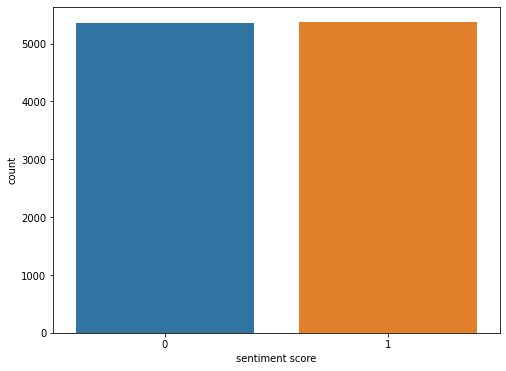

In [ ]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.Sentiment)
plt.xlabel('sentiment score');

In [ ]:
df['Sentiment'].value_counts()

1    5369
0    5358
Name: Sentiment, dtype: int64

In [ ]:
class_names = ['positive', 'negative']

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', model_max_length=512)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 512

In [ ]:
class News(Dataset):

    def __init__(self, sentiments, targets, tokenizer, max_len):
        self.sentiments = sentiments
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentiments)
    
    def __getitem__(self, item):
        sentiment = str(self.sentiments[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        sentiment,
        add_special_tokens=True,
        truncation=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'sentiment_text': sentiment,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=0)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((7508, 5), (2253, 5), (966, 5))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = News(
    sentiments=df.Headline_Clean.to_numpy(),
    targets=df.Sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
import torch
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [ ]:
EPOCHS = 4

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(-1,512).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [ ]:
input_ids[0]

tensor([[ 8113,  8038,  2983, 12698, 15221,  6997,  1614,   811,  1539,  2307,
          1042, 24107,   146,   493, 18839,   297,     4,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
outputs = model(input_ids.reshape(-1,512), token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

XLNetForSequenceClassificationOutput(loss=tensor(0.7434, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[-1.1177e-01, -6.5801e-01],
        [-2.8439e-04, -9.0551e-01],
        [-1.8818e-01, -5.3363e-01],
        [-1.0941e-01, -7.7579e-01],
        [-1.3517e-01, -6.5024e-01],
        [-1.0937e-01, -6.9294e-01],
        [-9.7291e-02, -6.8219e-01],
        [-1.3901e-01, -8.6226e-01]], device='cuda:0', grad_fn=<AddmmBackward0>), mems=(tensor([[[ 4.8711e-03,  5.2800e-02,  4.2355e-02,  ...,  1.3304e-03,
           6.5146e-03, -1.2271e-01],
         [-3.8695e-02, -9.8694e-03, -5.3354e-03,  ...,  6.4287e-02,
           1.9249e-02, -1.4396e-02],
         [-3.8695e-02, -9.8694e-03, -5.3354e-03,  ...,  6.4287e-02,
           1.9249e-02, -1.4396e-02],
         ...,
         [-3.8695e-02, -9.8694e-03, -5.3354e-03,  ...,  6.4287e-02,
           1.9249e-02, -1.4396e-02],
         [-3.8695e-02, -9.8694e-03, -5.3354e-03,  ...,  6.4287e-02,
           1.9249e-02, -1.4396e-02],
         [ 3

In [ ]:
type(outputs[0])

torch.Tensor

In [ ]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(-1,512).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(-1,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 100)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/XLNET_MODELDATA/XlNet_Model.bin')
        best_accuracy = val_acc

Epoch 1/4
----------------------------------------------------------------------------------------------------
Train loss 0.4858877947147345 Train accuracy 0.7707667731629393
Val loss 0.3478690733776448 Val accuracy 0.8865248226950354

Epoch 2/4
----------------------------------------------------------------------------------------------------
Train loss 0.28269685469632244 Train accuracy 0.9230564430244942
Val loss 0.4818905067676761 Val accuracy 0.9011524822695035

Epoch 3/4
----------------------------------------------------------------------------------------------------
Train loss 0.18843202872026496 Train accuracy 0.9543397231096912
Val loss 0.3952102256782047 Val accuracy 0.9171099290780141

Epoch 4/4
----------------------------------------------------------------------------------------------------
Train loss 0.13947084306278568 Train accuracy 0.9688498402555911
Val loss 0.4406345460069752 Val accuracy 0.9206560283687943

CPU times: user 1h 46min 52s, sys: 53.2 s, total: 1h 

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/XLNET_MODELDATA/XlNet_Model_1.bin'))

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.9659090909090909
Test Loss : 0.2567585254234345


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    sentiment_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["sentiment_text"]
            input_ids = d["input_ids"].reshape(-1,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            sentiment_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return sentiment_texts, predictions, prediction_probs, real_values

In [ ]:
y_sentiment_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.97      0.96      0.97       491
    negative       0.96      0.97      0.97       475

    accuracy                           0.97       966
   macro avg       0.97      0.97      0.97       966
weighted avg       0.97      0.97      0.97       966

